This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

You can download the dataset from kaggle

https://www.kaggle.com/snap/amazon-fine-food-reviews


The purpose of this model is to show an example of using fastText model for some supervised and unsupervised learning on a csv file.

In [1]:
import fastText
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Data preprocessing

Make the transformations in the csv to make it fastText compatible.

1. Label column should be first and all the needed text should be the second column
1. The labels should be prefixed with '__label__'.

In [2]:
df = pd.read_csv('data/amazon_reviews.csv')
df = df[['Score', 'Text']]
df['Score'] = df['Score'].apply(lambda x: '__label__'+str(x))

In [3]:
df.head()

,Score,Text
0,__label__5,I have bought several of the Vitality canned d...
1,__label__1,Product arrived labeled as Jumbo Salted Peanut...
2,__label__4,This is a confection that has been around a fe...
3,__label__2,If you are looking for the secret ingredient i...
4,__label__5,Great taffy at a great price. There was a wid...


Split the whole dataset into training and validation.
Then you will need to save the file generated. fastText uses the c++ api of the internal so that it is fasttext and it is able to read from a file only. Hence you cannot pass pandas dataframe or other general objects into fastText directly. It needs to be saved in a text file format.  Acceptable separators: space '\s' and tabs '\t'

In [4]:
train, test = train_test_split(df, test_size=0.2)
train_file = 'data/ft_amazon_reviews_train.csv'
test_file = 'data/ft_amazon_reviews_test.csv'
train.to_csv("data/ft_amazon_reviews_train.csv", sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False)
test.to_csv("data/ft_amazon_reviews_test.csv", sep="\t", quoting=csv.QUOTE_NONE, index=False, header=False)

## Model training

In [5]:
sg_model = fastText.train_supervised(input=train_file, epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)

## Model Performance

Simple precision and recall

In [6]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [7]:
print_results(*sg_model.test(test_file))

N	113691
P@1	0.827
R@1	0.827


Confusion matrix

In [8]:
test['Text'].head()

264989    I generally like anything coffee related so I ...
187976    ...if she could get her head out of this bag o...
157242    This tea is HIGHLY addictive.  I have a glass ...
101851    I'm a big fan of Walker's shortbread (Scotland...
370823    These are not original cliff bars, but the sma...
Name: Text, dtype: object

In [9]:
def get_true_postive_count(cm, model, df, label_column_name, text_column_name, target_class):
    predictions = [model.predict(x)[0][0] for x in df[df[label_column_name] == target_class][text_column_name]]
    tp_count = len(list(filter(lambda x: x==target_class, predictions)))
    index = np.where(cm==tp_count)
    if index[0][0] == index[1][0]:
        return index[0][0]
    else:
        raise ValueError('COuld not find the index ' + index)
        
        
def resolve_labels_sequence(classes, cm, model, df, label_column_name, text_column_name):
    target_seq = [0] * len(classes)
    for label in classes:
        index = get_true_postive_count(cm, model, df, label_column_name, text_column_name, label)
        target_seq[index] = label
    return target_seq


def fasttext_confusion_matrix(model, pd_test_data, label_column_name, text_column_name):
    test_labels = pd_test_data[label_column_name]
    test_labels = np.array(test_labels)
    _classes = list(set(test_labels))
    pred_labels = [model.predict(x)[0][0] for x in pd_test_data[text_column_name]]
    pred_labels = np.array(pred_labels)
    eq = test_labels == pred_labels
    print("Accuracy: " + str(eq.sum() / len(test_labels)))
    cm = confusion_matrix(test_labels, pred_labels)
    labels = resolve_labels_sequence(_classes, cm, model, pd_test_data, label_column_name, text_column_name)
    print(labels)
    print(confusion_matrix(test_labels, pred_labels, labels=labels))
    return cm, labels

In [10]:
cm, labels = fasttext_confusion_matrix(sg_model, test, 'Score', 'Text')

Accuracy: 0.8266793325768971
['__label__1', '__label__2', '__label__3', '__label__4', '__label__5']
[[ 8073   851   450   201   797]
 [ 1078  3269   831   333   539]
 [  487   636  5141  1133  1091]
 [  194   215   917  9507  5267]
 [  454   238   585  3408 67996]]


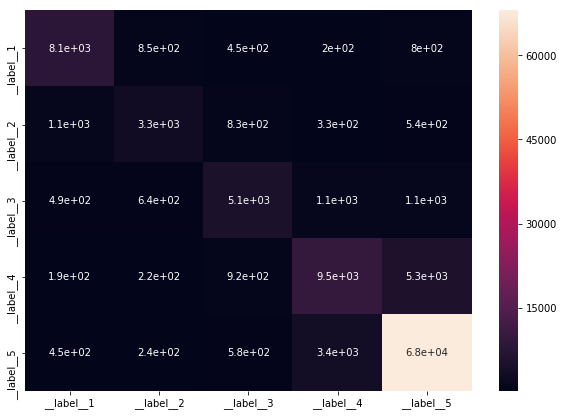

In [11]:
array = cm
df_cm = pd.DataFrame(array, index = labels, columns = labels)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)